### Lab01 Introduction to PyTorch, Building Models
#### csci e-104 Advanced Deep Learning



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

Training of Neural Networks usually requires fairly large datasets. In typical use cases, the dataset is too large to fit into the computer memory, and we need to load the data from the main storage device (the hard drive or solid-state drive) in chunks, that is, batch by batch (mini-batch would be more appropriate, but the term is not used). In addition, we may need to apply certain transformations and preprocessing steps to our data, such as mean centering, scaling, or adding noise to augment the training procedure and to prevent overfitting.

Applying preprocessing functions manually every time can be quite cumbersome. Luckily, PyTorch provides a special class for constructing efficient and convenient preprocessing pipelines. In this section, we will see an overview of different methods for constructing a PyTorch `Dataset` and `DataLoader`, and implementing data loading, shuffling, and batching.

### Creating a PyTorch DataLoader from existing tensors
If the data already exists in the form of a tensor object, a Python list, or a NumPy array, we can easily create a dataset loader using the `torch.utils.data.DataLoader()` class. It returns an object of the `DataLoader` class, which we can use to iterate through the individual elements in the input dataset. As a simple example, consider the following code, which creates a dataset from a list of values from 0 to 5:

In [2]:
from torch.utils.data import DataLoader
t = torch.arange(6, dtype=torch.float32)
data_loader = DataLoader(t)

We can easily iterate through a dataloader entry by entry as follows

In [3]:
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


If we want to create batches from this dataset, with a desired `batch_size` of 3, we can do this with the batch_size argument as follows:

In [4]:
data_loader = DataLoader(t, batch_size=3, drop_last=False)
for i, batch in enumerate(data_loader, 1):
    print(f'batch {i}:', batch)

batch 1: tensor([0., 1., 2.])
batch 2: tensor([3., 4., 5.])


This will create two batches from this dataset, where the first three elements go into batch #1, and the remaining elements go into batch #2. The optional drop_last argument is useful for cases when the number of elements in the tensor is not divisible by the desired batch size. We can drop the last non-full batch by setting drop_last to True. The default value for drop_last is False.

We can always iterate through a dataset directly, but as you just saw, DataLoader provides an automatic and customizable batching to a dataset.

### Combining two tensors into a joint dataset
Often, we may have the data in two (or possibly more) tensors. For example, we could have a tensor for features and a tensor for labels. In such cases, we need to build a dataset that combines these tensors, which will allow us to retrieve the elements of these tensors in tuples.

Assume that we have two tensors, `t_x` and `t_y`. Tensor `t_x` holds our feature values, each of size 3, and `t_y` stores the class labels. For this example, we first create these two tensors as follows:

In [5]:
torch.manual_seed(1)
t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)

Now, we want to create a joint dataset from these two tensors. We first need to create a `Dataset` class as follows:

In [1]:
from torch.utils.data import Dataset
class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


A custom Dataset class must contain the following methods to be used by the data loader later on:

`__init__()`: This is where the initial logic happens, such as reading existing arrays, loading a file, filtering data, and so forth.
`__getitem__()`: This returns the corresponding sample to the given index.

Notice that `__getitem__` returns a pair, feature `x[idx]` and the corresponding label`y[idx]`

Then we create a joint dataset of `t_x` and `t_y` with the custom `Dataset` class as follows:

In [7]:
joint_dataset = JointDataset(t_x, t_y)

# Finally, we can print each example of the joint dataset as follows:
for example in joint_dataset:
    print('  x: ', example[0], '  y: ', example[1])

  x:  tensor([0.7576, 0.2793, 0.4031])   y:  tensor(0)
  x:  tensor([0.7347, 0.0293, 0.7999])   y:  tensor(1)
  x:  tensor([0.3971, 0.7544, 0.5695])   y:  tensor(2)
  x:  tensor([0.4388, 0.6387, 0.5247])   y:  tensor(3)


If the second dataset is a labeled dataset in the form of tensors, instead of custom `JointDataset`, we could utilize the `torch.utils.data.TensorDataset` class. So, we can create a joint dataset as follows:

In [8]:
import torch.utils.data 
joint_dataset = torch.utils.data.TensorDataset(t_x, t_y)

### The PyTorch neural network module (torch.nn)
`torch.nn` is an elegantly designed module developed to help create and train NNs. It allows easy prototyping and the building of complex models in just a few lines of code.

### Building a linear regression model
First, we will build a simple model to solve a linear regression problem. We will create a toy dataset in NumPy and visualize it:

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# The one dimensional feature set contains tempreatures in degrees Celsius.
X_train = np.array([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0], dtype='float32').reshape(11,1)
# The lables, or target values are corresponding temperatures in degrees Fahrenheit
y_train = np.array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],dtype='float32').reshape(11,1)

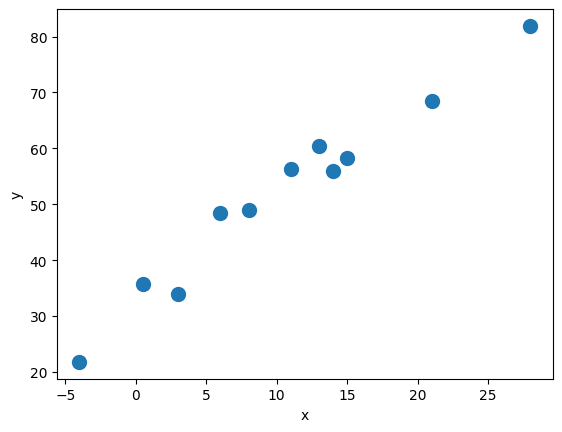

In [4]:
plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')

#plt.savefig('figures/temp_conversion.pdf')
plt.show()

If this were a real problem, our objective would have been to identify a linear mapping between degrees Celsius and degrees Fahrenheit.  Our real objective is to demonstrate how we formulate this optimization problem using PyTorch tools.

Next, we standardize the features. We do that by centering around the mean and by dividing with the standard deviation). Subsequently we create a PyTorch Dataset for the training set and a corresponding DataLoader:

In [5]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)

y_train = torch.from_numpy(y_train).float()

train_ds = TensorDataset(X_train_norm, y_train)

batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Here, we set a batch size of 1 for the DataLoader.

Now, we can define our model for linear regression as `z = wx + b`. Later, we will use the `torch.nn` module. It provides predefined layers for building complex NN models. To start, we will define a model from scratch. 

Parameters of our model, `w` and `b`, which correspond to the weight and the bias parameters, respectively. Finally, we define the `model()` function to determine how this model uses the input data to generate its output:

In [6]:
torch.manual_seed(1)
weight = torch.randn(1)
weight.requires_grad_()
bias = torch.zeros(1, requires_grad=True)

def model(xb):
    return xb @ weight + bias

After defining the model, we can define the loss function that we want to minimize to find the optimal model weights and biases. Here, we choose the mean squared error (MSE) as the loss function:

In [7]:
def loss_fn(input, target):
    return (input-target).pow(2).mean()

To learn the weight and bias parameters of the model, we use stochastic gradient descent. In the next few cells, we will implement this training via the stochastic gradient descent procedure by ourselves.

To implement the stochastic gradient descent algorithm, we need the gradients. Rather than manually computing the gradients, we will use PyTorch’s `torch.autograd.backward` function. 

We set the learning rate and train the model for 200 epochs. The code for training the model against the batched version of the dataset is as follows:

In [8]:
learning_rate = 0.001
num_epochs = 200
log_epochs = 10

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()

        with torch.no_grad():
            weight -= weight.grad * learning_rate
            bias -= bias.grad * learning_rate
            weight.grad.zero_()
            bias.grad.zero_()
 
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')
 

Epoch 0  Loss 2970.4653
Epoch 10  Loss 1516.7671
Epoch 20  Loss 1055.9792
Epoch 30  Loss 93.5062
Epoch 40  Loss 435.6532
Epoch 50  Loss 430.6850
Epoch 60  Loss 166.8562
Epoch 70  Loss 193.8103
Epoch 80  Loss 69.4148
Epoch 90  Loss 63.8855
Epoch 100  Loss 86.5727
Epoch 110  Loss 12.1916
Epoch 120  Loss 23.9387
Epoch 130  Loss 42.9017
Epoch 140  Loss 7.9525
Epoch 150  Loss 37.7350
Epoch 160  Loss 26.3088
Epoch 170  Loss 23.3251
Epoch 180  Loss 0.3198
Epoch 190  Loss 28.4715


We look at the trained model and plot it. For the test data, we will create a NumPy array of values evenly spaced between -5 and 32. Since we trained our model with standardized features, we will also apply the same standardization to the test data:

Final Parameters: 15.56026840209961 51.16802978515625


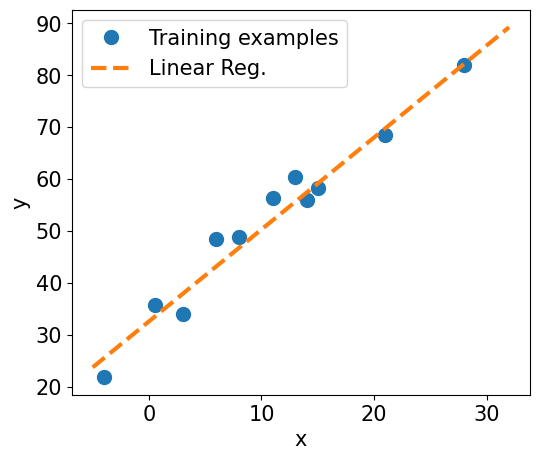

In [9]:
print('Final Parameters:', weight.item(), bias.item())
 
X_test = np.linspace(-5, 32, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)

plt.plot(X_train, y_train, 'o', markersize=10)
plt.plot(X_test, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('figures/custom_linear_regresion')

plt.show()

### Training via the `torch.nn` and `torch.optim` modules
In the previous example, we trained a model by writing a custom loss function `loss_fn()` and applied stochastic gradient descent optimization. However, writing the loss function and gradient updates can be a repeatable task across different projects. The `torch.nn` module provides a set of loss functions, and `torch.optim` supports most commonly used optimization algorithms that can update the parameters of the model based on the computed gradients. Let us create a new `MSE` loss function and a stochastic gradient descent optimizer,`torch.optim.SGD` :

In [10]:
import torch.nn as nn

input_size = 1
output_size = 1
model = nn.Linear(input_size, output_size)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Note that here we use the `torch.nn.Linear` class, instead of manually defining the `model` function.

Now, we can simply call the `step()` method of the optimizer to make individual gradient descent steps and train the model. We can pass a batched dataset (such as `train_dl`, which was created in one of previous cells):

In [11]:
# the training loop
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # 1. Generate predictions
        pred = model(x_batch) # [:, 0] 

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()
        
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss.item():.4f}')

Epoch 0  Loss 1083.9506
Epoch 10  Loss 797.1241
Epoch 20  Loss 1582.8890
Epoch 30  Loss 354.5439
Epoch 40  Loss 716.3844
Epoch 50  Loss 442.0590
Epoch 60  Loss 112.6398
Epoch 70  Loss 255.0096
Epoch 80  Loss 56.0229
Epoch 90  Loss 54.6631
Epoch 100  Loss 88.3830
Epoch 110  Loss 8.3145
Epoch 120  Loss 64.9706
Epoch 130  Loss 1.1656
Epoch 140  Loss 44.3407
Epoch 150  Loss 3.1074
Epoch 160  Loss 7.8621
Epoch 170  Loss 7.1797
Epoch 180  Loss 6.0365
Epoch 190  Loss 15.2261


Now that the model is trained, we can visualize the results. First print the weight and bias parameters,

In [19]:
print('Final Parameters:', model.weight.item(), model.bias.item())

Final Parameters: 15.545961380004883 51.16596984863281


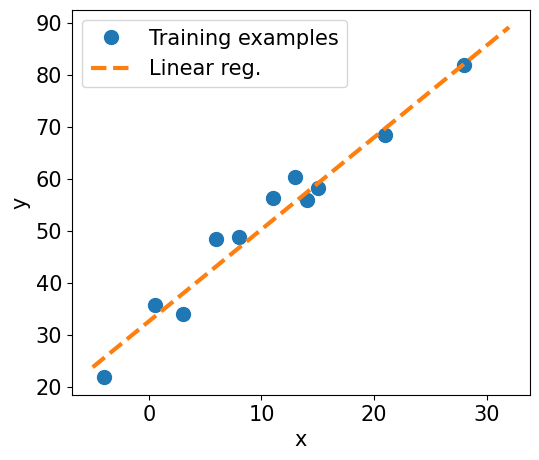

In [12]:
X_test = np.linspace(-5, 32, num=100, dtype='float32').reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm)
y_pred = model(X_test_norm).detach().numpy()


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)

plt.plot(X_train, y_train, 'o', markersize=10)
plt.plot(X_test, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
 
#plt.savefig('file/nn.Linear-linreg.pdf')

plt.show()

Loading and converting data into formats that are ready for training is often very time consuming. PyTorch
has developed standard conventions and tools for interacting with data that make that process fairly consistent
whether your data are images, text, audio, or other types.

The two main conventions of interacting with data are built into classes `Datasets` and `DataLoaders`. A
`Dataset` is a Python class that allows the access to the data we supply to the neural
network. Data loaders, i.e., objects of class `DataLoader` feed the data from the datasets into the networks. The data loader can
be given information such as: the batch size (number of images passed in at once) or the number of worker processes that will feed the data.

We look at the dataset first. As we have seen already, every dataset, no matter whether it includes images,
audio, text, 3D landscapes, stock market information, or any other data type, can interact with
PyTorch if it satisfies this abstract Python class `Dataset`:

This is fairly straightforward: we have to implement a method that returns the size of
our dataset (`__len__()`), and implement a method that can retrieve an item from our dataset
as (`label, tensor`) pair. This dataset, an object of class `Dataset` wil be called by the data loader as it is pushing data into the
neural network for training. 

We have to write a body for `__getitem__()` method that can take an
image, transform it into a tensor and return that tensor and the corresponding label. 